# Bank Customer Churn Analysis & Prediction

## Project Overview
Proyek ini bertujuan untuk menganalisis faktor-faktor yang mempengaruhi **churn** nasabah bank dan membangun model prediksi churn menggunakan **XGBoost**. Dengan memahami perilaku nasabah, bank dapat mengambil langkah strategis untuk **meningkatkan retensi pelanggan** dan **mengurangi churn**.

## Dataset
- **Jumlah baris:** 10,000  
- **Jumlah fitur:** 12+ (termasuk fitur numerik dan kategorikal)  
- **Target:** `churn` (0 = Tidak Churn, 1 = Churn)  
- Data mencakup informasi seperti `credit_score`, `age`, `tenure`, `balance`, `products_number`, `active_member`, `credit_card`, `estimated_salary`, dan `country`.

## Objective
1. Melakukan **Exploratory Data Analysis (EDA)** untuk memahami distribusi fitur, korelasi, dan pola churn.
2. Membuat **feature engineering** untuk menyoroti sinyal penting yang mempengaruhi churn.
3. Membangun model **XGBoost** untuk memprediksi churn nasabah.
4. Menyajikan **insight bisnis** dan rekomendasi strategis berdasarkan hasil analisis dan model.

## Key Insights
- Nasabah dengan **jumlah produk tinggi** (products_number) memiliki risiko churn lebih besar.  
- Nasabah yang **tidak menjadi member** cenderung lebih mudah churn → strategi loyalitas penting.  
- Skor kredit rendah sedikit meningkatkan risiko churn.  
- Kelompok usia 20-40 merupakan segmen penting, dengan spending dan income yang bervariasi.

## Business Recommendations
1. Fokus pada nasabah **high product number** dan **non-member** untuk strategi retensi (diskon, hadiah, program loyalitas).  
2. Berikan layanan atau edukasi tambahan kepada nasabah dengan **credit score rendah**.  
3. Monitoring perilaku nasabah menggunakan fitur-fitur utama untuk mengurangi churn di masa depan.

## Model Performance
- **Model:** XGBoost  
- **ROC-AUC:** 0.86  
- **Recall (churn class) optimal:** 0.71 (dengan threshold tuning)  
- Model mampu menangkap pola churn secara baik, terutama ketika threshold disesuaikan.

---



In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [2]:
df = pd.read_csv('Bank Customer Churn Prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [20]:
df.shape

(10000, 12)

In [4]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


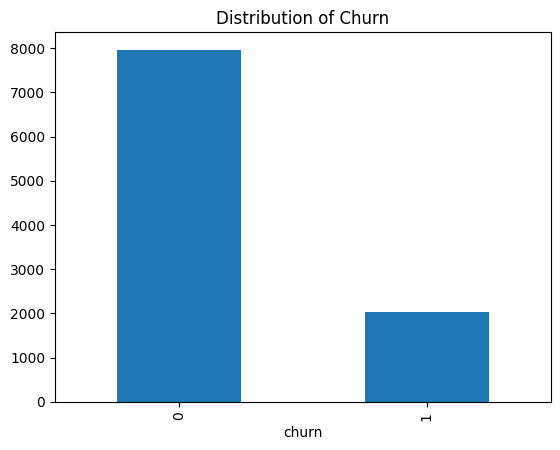

,proportion
churn,
0,0.7963
1,0.2037


In [22]:
df['churn'].value_counts().plot(kind='bar')
plt.title('Distribution of Churn')
plt.show()
df['churn'].value_counts(normalize=True)

##Dataset memiliki target imbalanced kategori standar bukan extreme

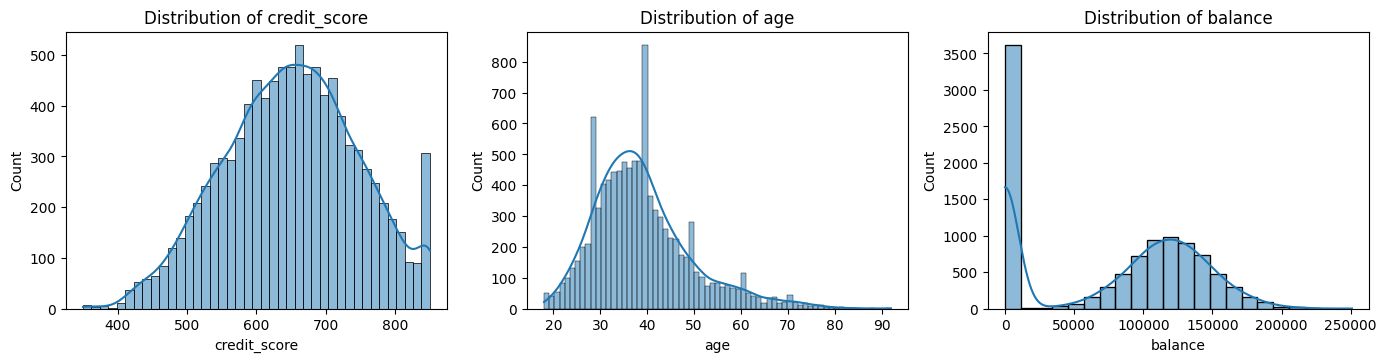

In [40]:
hist_plot = ['credit_score','age','balance']


plt.figure(figsize=(14,10))

for i, col in enumerate(hist_plot, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

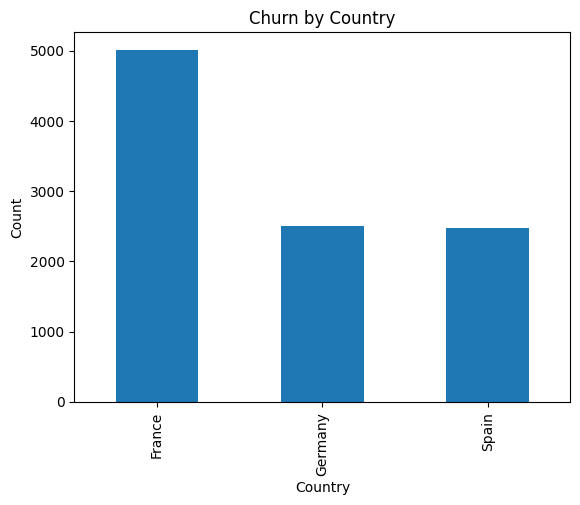

In [48]:
df.groupby('country')['churn'].count().plot(kind='bar')
plt.title("Churn by Country")
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

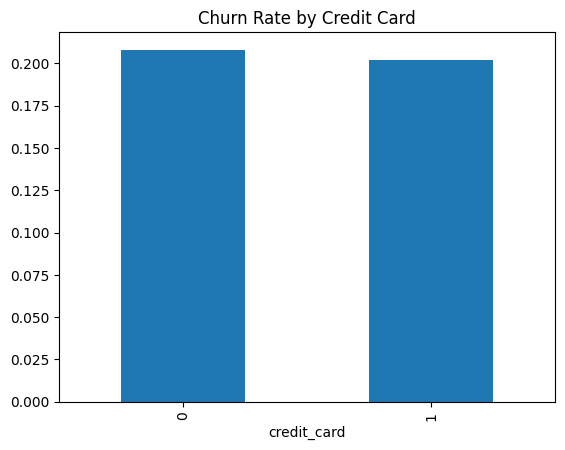

In [37]:
df.groupby('credit_card')['churn'].mean().plot(kind='bar')
plt.title('Churn Rate by Credit Card')
plt.show()



- Berdasarkan dataset, tidak terlihat perbedaan yang cukup signifikan antara nasabah yang memiliki credit card dan yang tidak memiliki credit card. Dengan demikian, fitur credit_card dapat dikategorikan sebagai sinyal yang lemah dalam menentukan apakah seorang nasabah akan churn atau tidak.

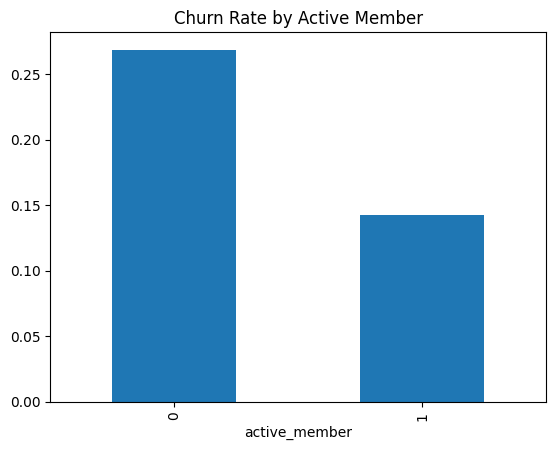

In [36]:
df.groupby('active_member')['churn'].mean().plot(kind='bar')
plt.title('Churn Rate by Active Member')
plt.show()


<h1>Churn lebih tinggi pada pelanggan tidak aktif member (active_member = 0)</h1>

- Selisih churn rate sekitar 11% menunjukkan adanya perbedaan yang cukup kuat antara nasabah yang aktif dan tidak aktif. Dengan demikian, fitur active_member dapat dikategorikan sebagai sinyal yang kuat dalam menentukan apakah seorang nasabah berpotensi churn atau tidak.

Alasan bisnis:

- active member = engagement tinggi

- pelanggan engaged → lebih loyal

- tidak aktif → jarang interaksi → mudah churn

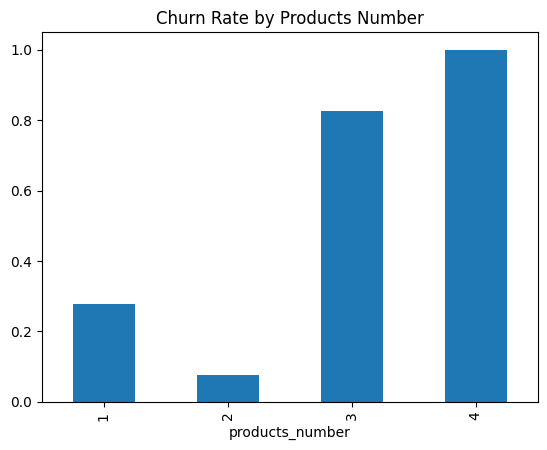

In [38]:
df.groupby('products_number')['churn'].mean().plot(kind='bar')
plt.title('Churn Rate by Products Number')
plt.show()

In [39]:
df['products_number'].value_counts()

,count
products_number,
1,5084
2,4590
3,266
4,60


Insight – Product Number vs Churn

- Nasabah dengan jumlah produk 3 dan 4 memiliki churn rate sangat tinggi (≈80% untuk 3 produk dan ≈100% untuk 4 produk).

- Hal ini menunjukkan bahwa fitur products_number merupakan sinyal yang sangat kuat dalam menentukan apakah nasabah berpotensi churn atau tidak.

- Namun, perlu diperhatikan kemungkinan adanya jumlah data yang lebih sedikit pada nasabah dengan 3–4 produk, sehingga analisis lanjutan tetap diperlukan untuk memastikan stabilitas temuan.

Business Recommendation

- Evaluasi kembali struktur harga dan manfaat setiap produk untuk memastikan kesesuaiannya dengan nilai yang diterima nasabah.

- Berikan insentif/diskon khusus kepada nasabah dengan jumlah produk tinggi untuk menurunkan risiko churn.

- Terapkan program loyalitas (reward, hadiah, benefit eksklusif) untuk nasabah dengan banyak produk sebagai bentuk apresiasi dan retensi.

In [52]:
num_fea = ['credit_score', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary']
cat_fea = ['country', 'gender']

In [53]:
X = df.drop(['churn', 'customer_id'], axis=1)
y = df['churn']


In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [58]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_fea),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_fea)
    ]
)


In [65]:
log_reg = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000, class_weight = 'balanced'))
])

log_reg.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['credit_score', 'age',
                                                   'tenure', 'balance',
                                                   'products_number',
                                                   'credit_card',
                                                   'active_member',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['country', 'gender'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [66]:
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1593
           1       0.39      0.70      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.71      0.74      2000

ROC-AUC: 0.7771824212502177


In [70]:
scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()
print("scale_pos_weight:", scale_pos_weight)

# =============================
# 5. XGBoost model
# =============================
xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

pipeline_xgb = Pipeline([
    ('preprocess', preprocess),
    ('model', xgb_model)
])

pipeline_xgb.fit(X_train, y_train)

# =============================
# 6. Prediction
# =============================
y_proba = pipeline_xgb.predict_proba(X_test)[:,1]

# default threshold 0.5
y_pred = (y_proba >= 0.5).astype(int)

print("\nClassification Report (threshold 0.5)")
print(classification_report(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_proba))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# =============================
# 7. Lower threshold (recall churn naik)
# =============================
threshold = 0.35
y_pred_low = (y_proba >= threshold).astype(int)

print(f"\nClassification Report (threshold={threshold})")
print(classification_report(y_test, y_pred_low))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_low))

scale_pos_weight: 3.9079754601226995

Classification Report (threshold 0.5)
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1593
           1       0.55      0.71      0.62       407

    accuracy                           0.82      2000
   macro avg       0.73      0.78      0.75      2000
weighted avg       0.84      0.82      0.83      2000

ROC AUC: 0.8558974999652966

Confusion Matrix:
[[1354  239]
 [ 120  287]]

Classification Report (threshold=0.35)
              precision    recall  f1-score   support

           0       0.93      0.74      0.83      1593
           1       0.44      0.80      0.57       407

    accuracy                           0.75      2000
   macro avg       0.69      0.77      0.70      2000
weighted avg       0.83      0.75      0.77      2000


Confusion Matrix:
[[1181  412]
 [  83  324]]


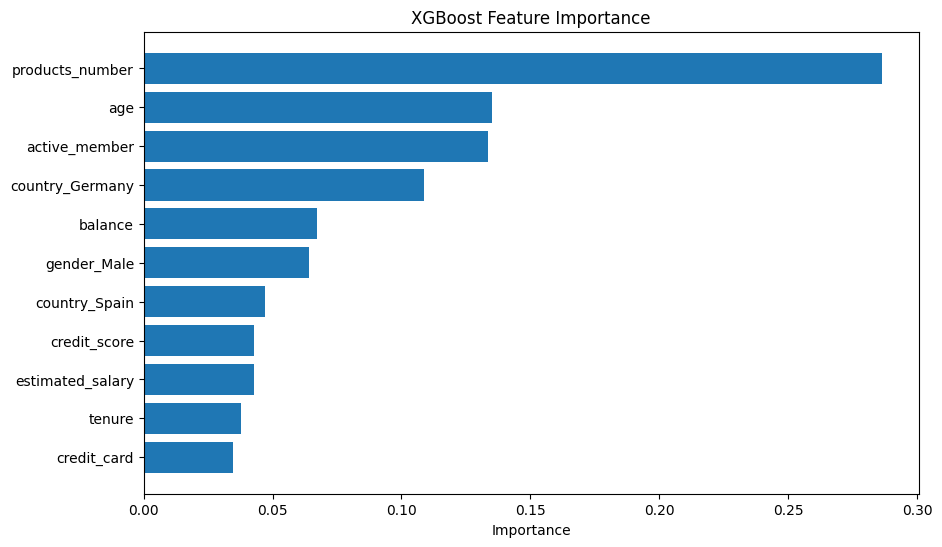

             feature  importance
4    products_number    0.286365
1                age    0.135310
6      active_member    0.133710
8    country_Germany    0.108689
3            balance    0.067179
10       gender_Male    0.063990
9      country_Spain    0.046891
0       credit_score    0.042911
7   estimated_salary    0.042813
2             tenure    0.037635
5        credit_card    0.034506


In [72]:
# Misal pipeline sudah fit, ambil model XGBoost nya
model = pipeline_xgb.named_steps['model']  # jika pakai Pipeline atau ImbPipeline
# jika tidak pakai pipeline: model = xgb_model

# Ambil nama fitur (numerical + hasil one-hot)
feature_names = num_fea + list(
    pipeline_xgb.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(cat_fea)
)

# Ambil importance dari model
importance = model.feature_importances_

# Buat DataFrame untuk visualisasi
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importance})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

# Visualisasi
plt.figure(figsize=(10,6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()  # fitur terpenting di atas
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.show()

# Tampilkan DataFrame untuk laporan / markdown
print(feat_imp)

Conclusion

Berdasarkan analisis data dan pemodelan churn nasabah bank menggunakan XGBoost, beberapa insight penting dapat diambil:

1. Fitur paling berpengaruh terhadap churn adalah:

- Products Number: Nasabah dengan jumlah produk lebih banyak memiliki risiko churn tinggi, menandakan kebutuhan untuk mengevaluasi harga atau memberikan insentif.

- Active Member: Nasabah yang tidak terdaftar sebagai member cenderung lebih mudah churn, sehingga program loyalitas sangat direkomendasikan.

- Credit Score: Nasabah dengan skor kredit rendah sedikit lebih berisiko churn, meskipun efeknya tidak sebesar produk dan status member.

2. Hasil model:

- Model XGBoost memberikan performa yang baik untuk mendeteksi churn, dengan ROC-AUC sekitar 0.86 dan f1-score kelas churn yang meningkat saat threshold disesuaikan.

- Penggunaan scale_pos_weight membantu menyeimbangkan dampak kelas minoritas (churn) tanpa perlu SMOTE dalam kasus ini.

3. Rekomendasi bisnis:

- Fokus pada nasabah dengan produk terbanyak dan nasabah non-member untuk strategi retensi, misalnya dengan diskon, hadiah, atau program loyalitas.

- Perhatikan nasabah dengan skor kredit rendah dan berikan edukasi atau layanan tambahan untuk meningkatkan retensi.

- Monitoring terus perilaku nasabah berdasarkan fitur yang paling berpengaruh untuk meminimalkan churn di masa depan.
